<a href="https://colab.research.google.com/github/VictorBbt/SketchToReality/blob/main/Inference_with_BLIP_2_(int8).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Chat with BLIP-2

In this notebook, we'll illustrate the new BLIP-2 model by Salesforce, which can be used for state-of-the-art image captioning, visual question answering and overall chatting related to images.

In this notebook, we'll showcase the [int8 quantization algorithm](https://huggingface.co/blog/hf-bitsandbytes-integration) by bitsandbytes, which allows to run giant model on fairly common hardware, like the hardware powering Google Colab.

## Set-up environment

We'll start by installing 🤗 Transformers. As the model is brand new at the time of writing this notebook, we install it from source.

Note that it's advised to run this notebook on a GPU environment, high RAM.

In [ ]:
!pip install -q git+https://github.com/huggingface/transformers.git accelerate bitsandbytes

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 280.0/280.0 kB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.0/105.0 MB 8.7 MB/s eta 0:00:00


In [ ]:
#import requests
#from PIL import Image

#url = 'https://storage.googleapis.com/sfr-vision-language-research/LAVIS/assets/merlion.png'
#image = Image.open(requests.get(url, stream=True).raw).convert('RGB')
#display(image.resize((596, 437)))

## Load model and processor

We can instantiate the model and its corresponding processor from the [hub](https://huggingface.co/models?other=blip-2). Here we load a BLIP-2 checkpoint that leverages the pre-trained OPT model by Meta AI, which as 2.7 billion parameters.

In [ ]:
from transformers import AutoProcessor, Blip2ForConditionalGeneration
import torch

processor = AutoProcessor.from_pretrained("Salesforce/blip2-opt-2.7b")

# there are several ways to load the model:
# model = Blip2ForConditionalGeneration.from_pretrained("Salesforce/blip2-opt-2.7b") # load in float32
# model = Blip2ForConditionalGeneration.from_pretrained("Salesforce/blip2-opt-2.7b", torch_dtype=torch.float16) # load in float16
model = Blip2ForConditionalGeneration.from_pretrained("Salesforce/blip2-opt-2.7b", device_map="auto", load_in_8bit=True) # load in int8

# here we use int8 since float32 is too big to fit in the RAM with colab, and float16 is not supported on CPU

The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

## Load Sketchy dataset

First, let's mount our Google Drive content

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd drive/MyDrive/SketchToReality/

/content/drive/.shortcut-targets-by-id/1CWuL-Kv12lc1O0peSApcvTKUaHIxphWx/SketchToReality


In [ ]:
from PIL import Image
import os
import numpy as np
import glob

sketch_path = './Data/data/sketch/tx_000000000000/*/*'
list_all_files = []
for file in glob.glob(sketch_path, recursive=True):
    list_all_files.append(file)

Label: church


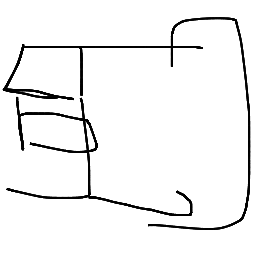

In [ ]:
random_sketch_idx = np.random.randint(0, len(list_all_files))
random_sketch_path = list_all_files[random_sketch_idx]
label = random_sketch_path.split(sep='/')[-2]
RandomSketch = Image.open(random_sketch_path)
print(f'Label: {label}')
display(RandomSketch)

## Image captioning

If you don't provide any text prompt, then the model will by default start generating text from the BOS (beginning-of-sequence) token. So it will generate a caption for the image.

In [ ]:
inputs = processor(RandomSketch, return_tensors="pt")

generated_ids = model.generate(**inputs, max_new_tokens=20)
generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0].strip()
print(generated_text)

a drawing of a person with a face and a hat


## Prompted image captioning

You can provide a text prompt, which the model will continue given the image.

In [ ]:
prompt = "this is a art sketch of"

inputs = processor(RandomSketch, text=prompt, return_tensors="pt")

generated_ids = model.generate(**inputs, max_new_tokens=20)
generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0].strip()
print(generated_text)

a person with a face


In [ ]:
prompt = "the view point of this art sketch is"

inputs = processor(RandomSketch, text=prompt, return_tensors="pt")

generated_ids = model.generate(**inputs, max_new_tokens=20)
generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0].strip()
print(generated_text)

the view of the person


## Visual question answering (VQA)

In [ ]:
prompt = "Question: what is represented in this sketch and how is it portrayed? Answer:"

inputs = processor(RandomSketch, text=prompt, return_tensors="pt")

generated_ids = model.generate(**inputs, max_new_tokens=10)
generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0].strip()
print(generated_text)

the head of a man


## Chat-based prompting

We can create a ChatGPT-like interface by simply concatenating each generated response to the conversation. We prompt the model with some text (like "which city is this?"), the model generates an answer for it "Singapore"), which we just concatenate to the conversation. Then we ask a follow-up question ("why?") which we also just concatenate and feed to the model.

This means that the context can't be too long - models like OPT and T5 (the language models being used in BLIP-2) have a context length of 512 tokens.

In [ ]:
context = [
    ("what is this image?", "it is an art sketch, a drawing"),
    ("what is represented by this sketch?", "it represents a " + label),
]
question = "what is the most detailed description of this sketch?"
template = "Question: {} Answer: {}."

prompt = " ".join([template.format(context[i][0], context[i][1]) for i in range(len(context))]) + " Question: " + question + " Answer:"

print(prompt)

Question: what is this image? Answer: it is an art sketch, a drawing. Question: what is represented by this sketch? Answer: it represents a church. Question: what is the most detailed description of this sketch? Answer:


In [ ]:
inputs = processor(RandomSketch, text=prompt, return_tensors="pt") #.to(device, torch.float16)

generated_ids = model.generate(**inputs, max_new_tokens=10)
generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0].strip()
print(generated_text)

it is a church.
